## Optics simulation (basic)
First pupil plane to focal plane. Serves as tests

In [38]:
from __future__ import division
exec(open('./prep.py'))
exec(open('./codes/func.py'))
% matplotlib inline

In [39]:
# parameters
N_pix = 1024
D_tel = 7.8 * u.m
lba   = 1.65 * u.um
Sampfreq = 8 ## number of pixels per lambda/D

## 
pix_scale = D_tel / N_pix * Sampfreq ## physical scale
k_pix_arc = ((lba/Sampfreq/D_tel).to(u.dimensionless_unscaled)*u.rad).to(u.arcsec)
R_tel_p = N_pix / Sampfreq / 2 ## in pixel

In [40]:
k_pix_arc

<Quantity 0.005454117472879952 arcsec>

In [41]:
## centroid
ctx,cty = int((N_pix-1)/2), int((N_pix-1)/2) 

### Uniform illumination with no phase

In [42]:
# inputs
##
One = np.ones((N_pix,N_pix))
Zer = np.zeros((N_pix,N_pix))

## uniform illumination with no phase
Amp = cmask(Zer,R_tel_p)
Pha = cmask(Zer,R_tel_p,fill=0) * u.rad

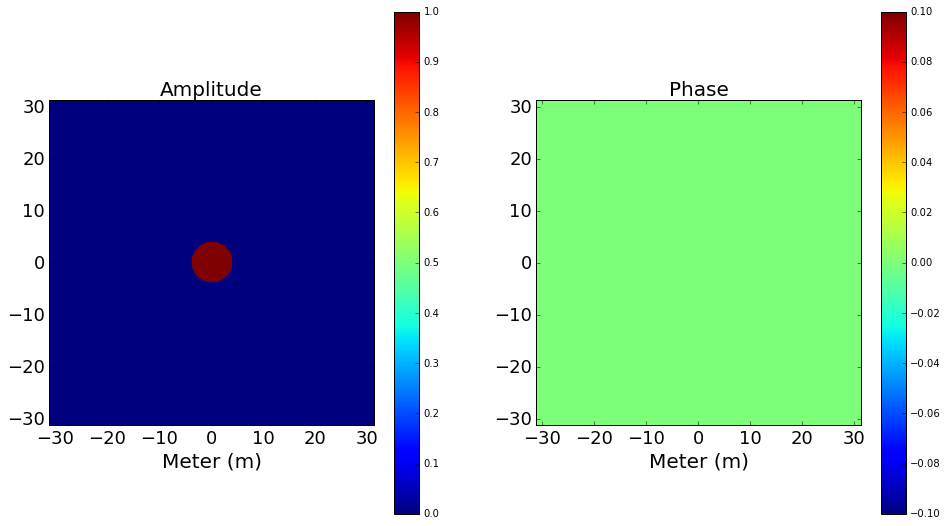

In [44]:
## ticks
x_min, x_max = ((0-ctx)*pix_scale).value,((N_pix-ctx)*pix_scale).value
y_min, y_max = ((0-cty)*pix_scale).value,((N_pix-cty)*pix_scale).value

##
plt.figure(figsize=(16,9))
plt.subplot(121); plt.imshow(Amp, origin='lower', extent=(x_min,x_max,y_min,y_max))
plt.title('Amplitude',fontsize=20); plt.xlabel('Meter (m)',fontsize=20); 
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.colorbar()
#plt.xlim(482,542); plt.ylim(482,542)
plt.subplot(122); plt.imshow(Pha.value, origin='lower', extent=(x_min,x_max,y_min,y_max))
plt.title('Phase',fontsize=20); plt.xlabel('Meter (m)',fontsize=20); 
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.colorbar()

In [45]:
first_foc_ef  = Ef_after(Amp,Pha)
first_foc_int = Int_after(Amp,Pha)

In [46]:
#--- True Airy disk ---#
from scipy.special import jn
kx,ky = np.meshgrid(np.fft.fftshift(np.fft.fftfreq(N_pix,d=1/(2*np.pi))),
                    np.fft.fftshift(np.fft.fftfreq(N_pix,d=1/(2*np.pi))))


kr = np.sqrt(kx**2+ky**2) + 1e-10 ## prevent divide by zero

####
a = R_tel_p

##
airy = jn(1,kr*a)/(kr*a)
airy[ctx,cty] = 0.5

Int_air_ = abs(airy)**2
Int_airy = Int_air_/np.max(Int_air_)

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 <a list of 8 Text yticklabel objects>)

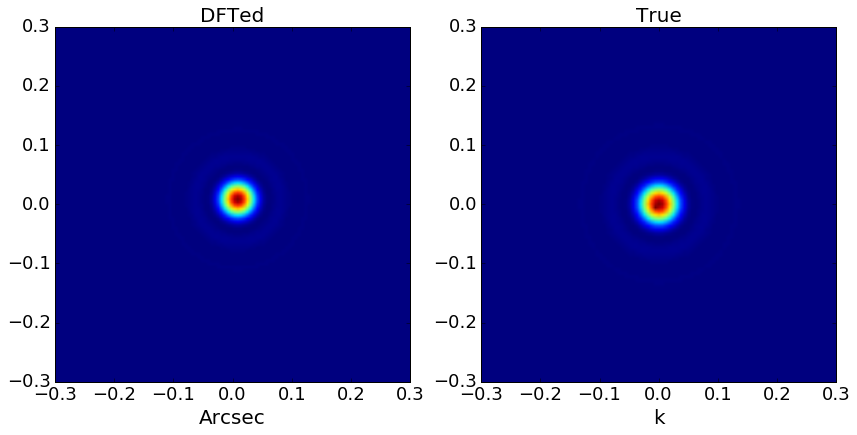

In [47]:
##
kx_min,kx_max = ((0-ctx)*k_pix_arc).value,((N_pix-ctx)*k_pix_arc).value
ky_min,ky_max = ((0-cty)*k_pix_arc).value,((N_pix-cty)*k_pix_arc).value

##
plt.figure(figsize=(14,7))
plt.subplot(121); plt.imshow(first_foc_int, origin='lower',
                             extent=(kx_min,kx_max,ky_min,ky_max))
plt.xlim(-0.3,0.3); plt.ylim(-0.3,0.3)
plt.title('DFTed',fontsize=20); plt.xlabel('Arcsec',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.subplot(122); plt.imshow(Int_airy, origin='lower',
                             extent=(kx.min(),kx.max(),ky.min(),ky.max()))
plt.xlim(-0.3,0.3); plt.ylim(-0.3,0.3)
plt.title('True',fontsize=20); plt.xlabel('k',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)

Note that the scales in the two plots are actually different: one (_left_) in `arcsec` from pixel values, one (_right_) ranging from $-\pi$ to $\pi$

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 <a list of 8 Text yticklabel objects>)

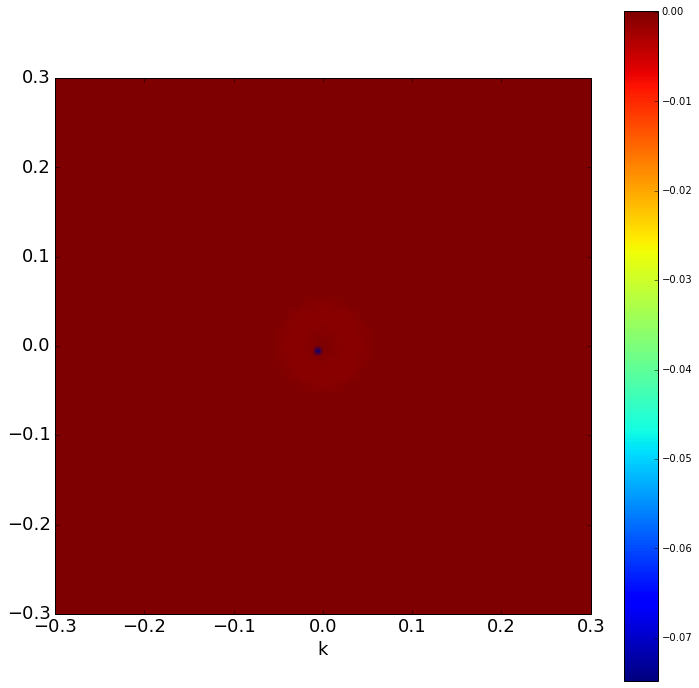

In [48]:
plt.figure(figsize=(12,12))
plt.imshow(first_foc_int-Int_airy, origin='lower',extent=(kx.min(),kx.max(),ky.min(),ky.max())); 
plt.colorbar(); plt.xlim(-0.3,0.3); plt.ylim(-0.3,0.3), plt.xlabel('k', fontsize=18)
plt.xticks(fontsize=18); plt.yticks(fontsize=18)

Looks like at this (low) sampling frequency, the two agree pretty well.

We can only look at the absolute values rather than the (squared) intensity:

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 <a list of 8 Text yticklabel objects>)

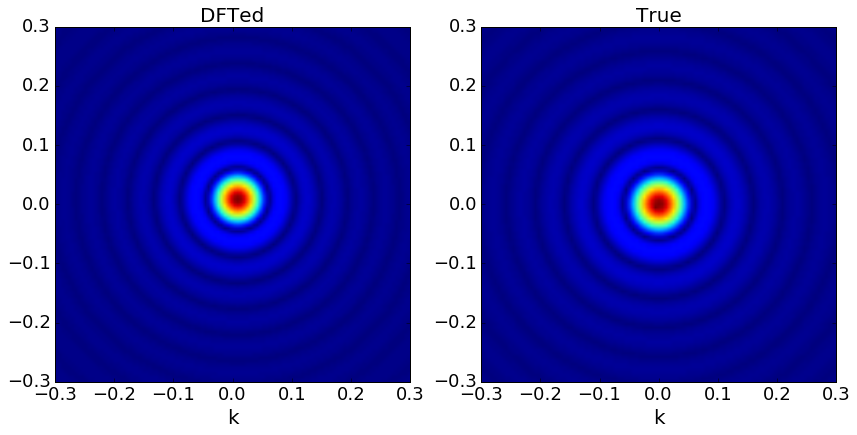

In [49]:
plt.figure(figsize=(14,7))
plt.subplot(121); plt.imshow(np.sqrt(first_foc_int), origin='lower',
                             extent=(kx_min,kx_max,ky_min,ky_max))
plt.xlim(-0.3,0.3); plt.ylim(-0.3,0.3)
plt.title('DFTed',fontsize=20); plt.xlabel('k',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.subplot(122); plt.imshow(np.sqrt(Int_airy), origin='lower',
                             extent=(kx.min(),kx.max(),ky.min(),ky.max()))
plt.xlim(-0.3,0.3); plt.ylim(-0.3,0.3)
plt.title('True',fontsize=20); plt.xlabel('k',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)

#### How about transform it back again?
Sanity check for the physical scale conversions

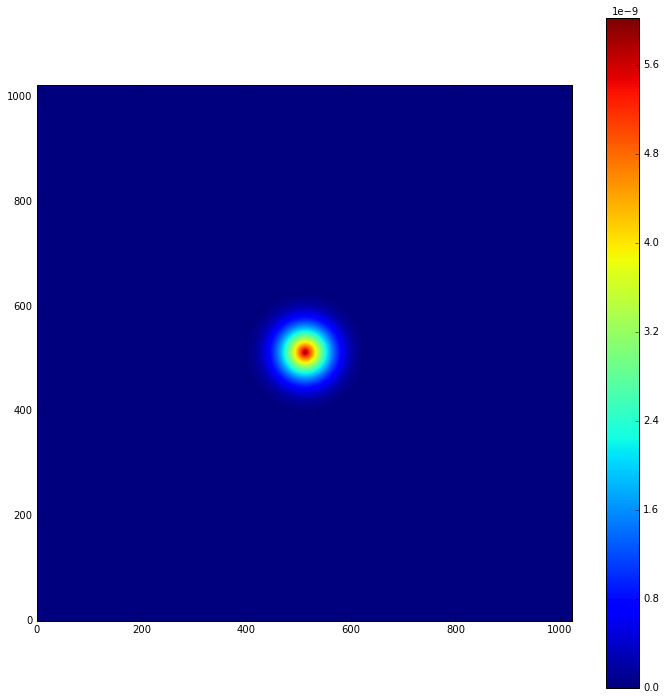

In [50]:
amp_,pha_ = Ef_to_AP(Int_after(Amp,Pha))
plt.figure(figsize=(12,12))
#plt.imshow(Int_after(amp_,pha_),origin='lower')
plt.imshow(abs(np.fft.ifftshift(np.fft.ifft2(Int_after(Amp,Pha))))**2,origin='lower')
plt.colorbar()

This is the inverse transform of the "Airy pattern". Instead, we should recover the uniform disk by transforming the electrif field in the focal plane:

(array([ -200.,     0.,   200.,   400.,   600.,   800.,  1000.,  1200.]),
 <a list of 8 Text yticklabel objects>)

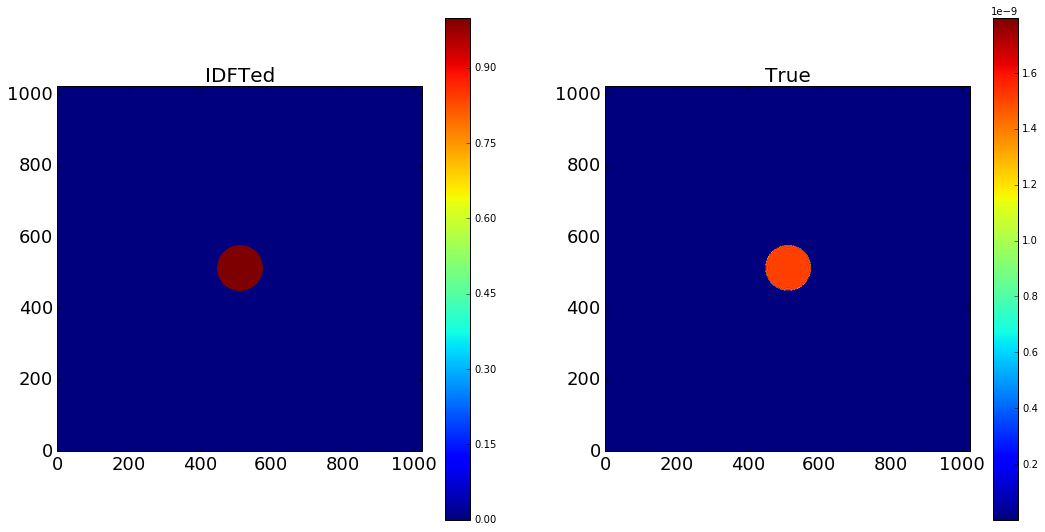

In [51]:
### DFTed
IFTed = abs(np.fft.ifft2(Ef_after(Amp,Pha)))**2
### Airy pattern 
IFTtr = abs(np.fft.ifftshift(np.fft.ifft2(airy)))**2

plt.figure(figsize=(18,9))
plt.subplot(121); plt.imshow(IFTed, origin='lower'); plt.colorbar()
plt.title('IDFTed',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.subplot(122); plt.imshow(IFTtr, origin='lower'); plt.colorbar()
plt.title('True',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)

Let's ignore the "normalization" for a moment....

Of course, due to Parseval's theorem, FFT does the same thing...

(array([ -200.,     0.,   200.,   400.,   600.,   800.,  1000.,  1200.]),
 <a list of 8 Text yticklabel objects>)

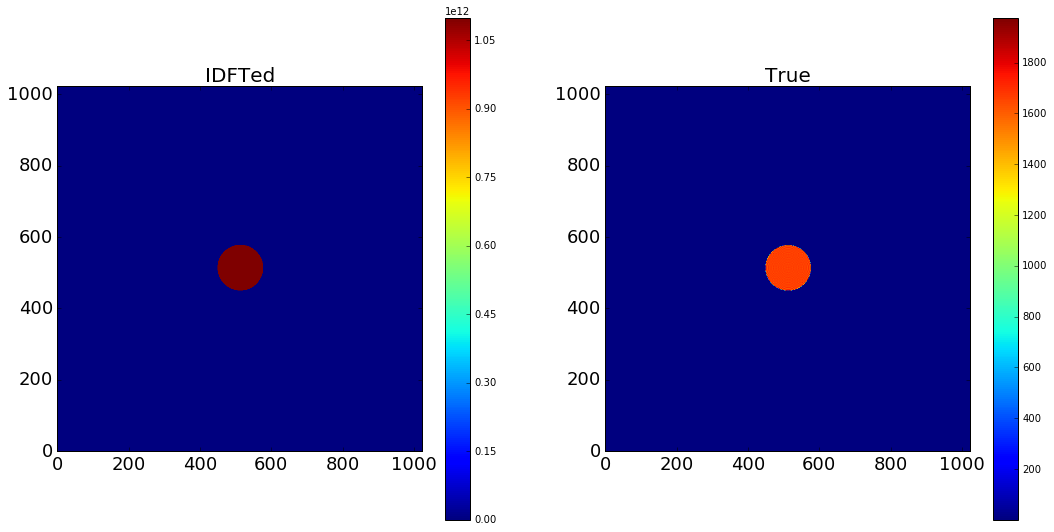

In [52]:
### DFTed
dDFTed = abs(np.fft.fft2(Ef_after(Amp,Pha)))**2
### Airy pattern 
dDFTtr = abs(np.fft.fftshift(np.fft.fft2(airy)))**2

plt.figure(figsize=(18,9))
plt.subplot(121); plt.imshow(dDFTed, origin='lower'); plt.colorbar()
plt.title('IDFTed',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.subplot(122); plt.imshow(dDFTtr, origin='lower'); plt.colorbar()
plt.title('True',fontsize=20); plt.xticks(fontsize=18); plt.yticks(fontsize=18)